# Plots for Conformism Project

In [68]:
#from PIL import Image
#import sys
#sys.path.append('/usr/local/lib/python3.7/site-packages')
import os
import numpy as np
import importlib
from numpy import linalg
from helperfuns import *
from DatFrameFuns import *
import scipy.stats as scs
import matplotlib as mpl
import matplotlib.pyplot as plt
#importlib.reload(helperfuns)
import pandas as pd
import sympy as sp
from sympy import *
from sympy.solvers import solve
np.set_printoptions(precision=6, suppress = True)
import seaborn as sns
# next two libraries are used to flatten list of lists
import functools
import operator
# for formatting tick labels
from matplotlib.ticker import FormatStrFormatter
import timeit
from ternary import *

## Plots should be separated by when $p_1 = p_2$ and $p_1 \neq p_2$

First load necessary dataframes: df_eq, df_lambdas

In [69]:
def get_gradients(df_eq):
    u1vec = df_eq.u1eq
    u2vec = df_eq.u2eq
    r1vec = df_eq.r1eq
    r2vec = df_eq.r2eq
    Wvec = df_eq.Weq
    Kvec = df_eq.K
    Dvec = df_eq.D
    dvec = df_eq.d
    muvec = df_eq.mu
    Cdvec = [Grad_d([u1,u2], [r1,r2], W, D, d, mu) for u1,u2,r1,r2,W,D,d,mu in zip(u1vec,u2vec,r1vec,r2vec,Wvec,Dvec,dvec,muvec)]
    CDvec = [Grad_D([u1,u2], [r1,r2], W, K,D) for u1,u2,r1,r2,W,K,D in zip(u1vec,u2vec,r1vec,r2vec,Wvec,Kvec,Dvec)]
    df_eq['C_d'] = Cdvec
    df_eq['C_D'] = CDvec
    return(df_eq)

# fixing data


In [70]:
df_10steps = param_grid_phase_plot(FineGrid=True)
df_10steps = df_Xsteps(df_10steps)
df_10steps = reflect_df_Xsteps(df_10steps)
df_main = pd.read_csv('data.csv')


df_reached_eq = df_main.query('reached_eq==1')

In [5]:
unique_eq = get_UniqueEquilibria(df_main)
diff = np.abs(unique_eq.u1eq - unique_eq.u2eq)
unique_eq['difference'] = diff

In [10]:
unique_eq.to_csv('UniqueEquilibriaDF.csv')

In [8]:
weirdEq = unique_eq.query('URstable==-1')

## Trajectory for K = 1, D = 0

In [85]:
len(df_main)

276480

In [92]:
df_inits = df_main.query('beta==0.5 & D.round(1) == 0.2 & d.round(1) == 0.5 & mu.round(1) == 0.5')
df_inits = df_inits[['u1init', 'u2init', 'buinit', 'r1init', 'r2init']]
df_inits.reset_index(inplace=True, drop=True) 

In [95]:
df_inits.index.values

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63])

In [120]:
def get_trajectory(row, beta, tsteps = 1000, K = 1, pc = 0, D = 0):
    u1init = row.u1init; u2init = row.u2init; buinit = row.buinit;
    r1init = row.r1init; r2init = row.r2init;
    uvec = [u1init, u2init, buinit]
    xvec = [0,0,0]
    yvec = [0,0,0]
    rvec = [r1init, r2init]
    
    [u1_traj, u2_traj, bu_traj, r1_traj, r2_traj] = [np.zeros(tsteps),np.zeros(tsteps),np.zeros(tsteps),
                                                     np.zeros(tsteps),np.zeros(tsteps)]
    time = np.arange(0,tsteps)
    [u1_traj[0], u2_traj[0], bu_traj[0], r1_traj[0], r2_traj[0]] = [*uvec, *rvec]
    for t in time:
        result = NextGen(uvec,xvec,yvec,rvec, D, K,pc , beta = beta)
        uvec, xvec, yvec, rvec, W = result
        [u1_traj[t], u2_traj[t], bu_traj[t]] = uvec
        [r1_traj[t], r2_traj[t]] = rvec
    which_traj = row.name
    data = {'time': time, 'beta': beta, 'which_traj': which_traj, 
            'u1_t': u1_traj, 'u2_t': u2_traj,
            'bu_t': bu_traj, 'r1_t': r1_traj, 'r2_t': r2_traj}
    df = pd.DataFrame(data = data)
    return(df)

In [149]:
# plot a trajectory'
#df_inits.head().apply(lambda row: get_trajectory(row,0), axis = 1)
beta = 0
row = df_inits.iloc[1,:]
dflist = tuple([tuple(df_inits.apply(lambda row: get_trajectory(row,beta), axis = 1)) for beta in [0,0.5,1]])
columns = ['time','beta', 'which_traj','u1_t','u2_t','bu_t','r1_t','r2_t']
df_traj = np.vstack(dflist)
df_traj= pd.DataFrame(df_traj, columns = columns)

In [155]:
df_traj.to_csv('K1D0_trajectories.csv')

## Where are equilibria externally unstable?  Mostly when u1eq = u2eq. When u1 != u2 and the equilibria is not URstable, we have beta = 1,  D = 0.6, and pc/K < 0.0035 with K > 0.97

In [37]:
D = -2
beta = 1
u1 = 0.2
print(Cdsign(D, beta, u1))
phi_fun(0)

-1.7695999999999998


0

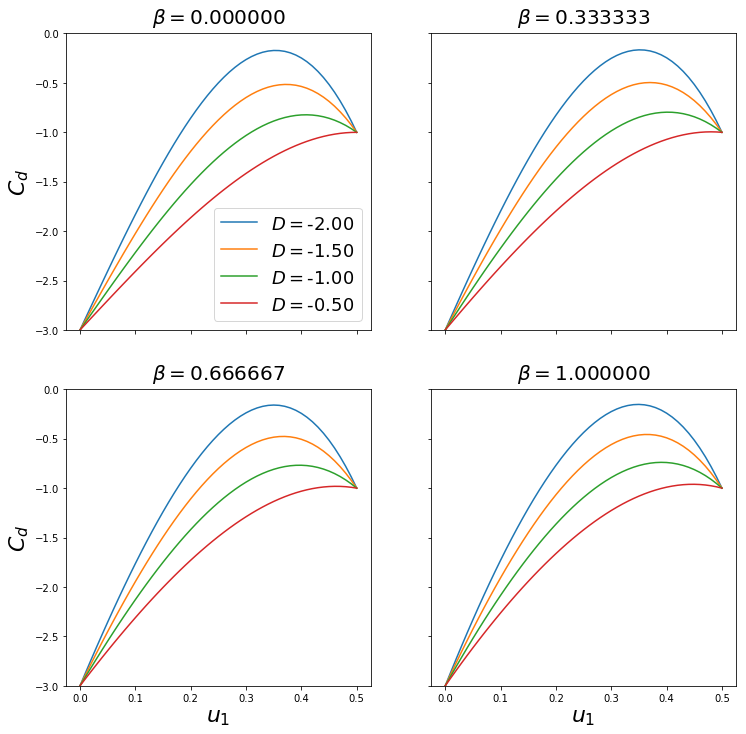

In [66]:
#K = 0, D < 0 plot

Dvals = np.arange(-2,0,0.5)
betavals = np.linspace(0,1,4)
u1vals = np.arange(0,0.51,0.01)
def Cdsign(D,beta,u1):
    to_return = 2*(2 - beta*u1)*(2*(u1 + D*phi_fun(u1)) -1)-2*(2*u1 + D*phi_fun(2*u1)) +1
    return(to_return)

fig,axmat = plt.subplots(2,2,sharex = 'all', sharey = 'all',figsize = (12,12))
numD = len(Dvals) # it's 4

for beta,ax in zip(betavals,axmat.flat):
    for D in Dvals:
        line = [Cdsign(D,beta,u1) for u1 in u1vals]
        label = r'$D = $%0.2f' %D
        ax.plot(u1vals, line, label = label)
    title = r'$\beta = $%f' %beta
    
    ax.set_title(title,pad = 10, fontsize = 20)
    ax.set_ylim([-3,0])
axmat[0,0].legend(fontsize = 18, loc = 'lower right')
xlab = r'$u_1$'
ylab = r'$C_d$'
axmat[-1,0].set_xlabel(xlab, fontsize = 22)
axmat[-1,1].set_xlabel(xlab, fontsize = 22)
axmat[0,0].set_ylabel(ylab, fontsize = 22)
axmat[1,0].set_ylabel(ylab, fontsize = 22)
fig.savefig('Figures/Cd_K0_Dneg.png')

# When (d,D) combos are unstable to increased social learning or conformity?

In [84]:
UStable_unique_eq = unique_eq.query('URstable==1')
KInvades = UStable_unique_eq.query('C_d>0')
DInvades = unique_eq.query('C_D>0')
KInvades_u1isu2 = KInvades.query('difference==0')
KInvades_u1notu2 = KInvades.query('difference>0')
DInvades_u1isu2 = DInvades.query('difference==0')
DInvades_u1notu2 = DInvades.query('difference>0')

K Invades only if $\mu < 0$

Text(0.5, 0, 'D')

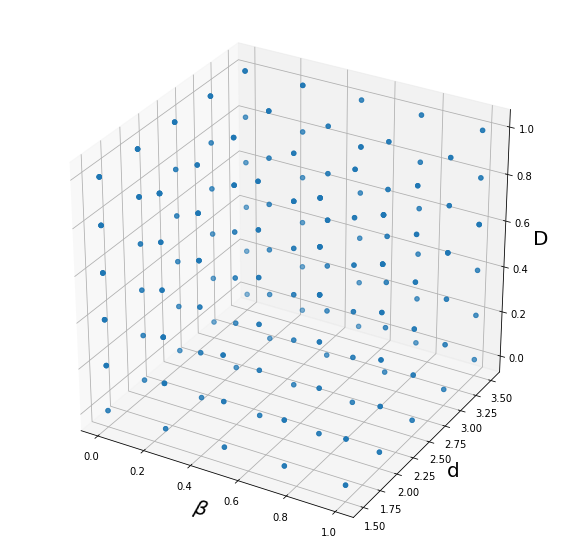

In [56]:
# need to see how d, beta, and D influences invasion
# 
#plt.scatter(KInvades_u1notu2.beta,KInvades_u1notu2.d)
from mpl_toolkits.mplot3d import Axes3D
df_use = KInvades_u1notu2.query('mu ==-1')
fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df_use.beta, df_use.d,df_use.D)
ax.set_xlabel(r'$\beta$', fontsize = 20)
ax.set_ylabel('d', fontsize = 20)
ax.set_zlabel('D', fontsize = 20)


# What are the equilibria for $D = 0$, $K \in (0,1)$?

array([nan, nan])

In [17]:
def D0sol1(K,pc,beta):
    # uses the equation for the solution that i got with sympy
    # returns the plus and minus versions of the solution. returns [np.nan, np.nan] if discriminant < 0
    term1 = (K*beta + K -2*pc*beta)/(4*K*beta)
    discrim = K**2*(beta-1)**2 +4*beta*(K*pc -K + pc*beta)
    if discrim < 0:
        return(np.array([np.nan, np.nan]))
    else:
        term2 = np.sqrt(discrim)/(4*K*beta)
        
    sol = [term1 - term2, term1 + term2]
    return(sol)
svals = np.arange(0,4,0.1)# i'm using s now instead of little d
muvals = np.arange(-1,1,0.1)
bvals = np.arange(0,1.25,0.25)


S, MU, B = np.meshgrid(svals, muvals, bvals)
svec = np.ndarray.flatten(S); muvec = np.ndarray.flatten(MU)
norms = scs.norm(muvec,1)
Kvec = Kfun(svec,norms)
pcvec = pcfun(svec,norms)

s

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8,
       3.9])

# Phase Portrait of Gradients

# Draw the triangles (I forget what these are called)

In [8]:
import ternary as tern
from ternary import helpers
def draw_ternary_simplex(ax, title = '', left_corner_label = r'$\bar{u} = 1$', right_corner_label = r'$u_1 = 1$', 
                         top_corner_label = r'$u_2 = 1$', fontsize = 20, grid_on = False, scale = 1):
## Boundary and Gridlines
    figure, tax = tern.figure(ax=ax, scale=scale)

    # Draw Boundary and Gridlines
    tax.boundary(linewidth=2.0)
    if grid_on:
        tax.gridlines(color="black", multiple=5)
        tax.gridlines(color="blue", multiple=1, linewidth=0.5)

    # Set Axis labels and Title
    tax.set_title(title, fontsize=fontsize)
    tax.right_corner_label(right_corner_label, fontsize=fontsize)
    tax.left_corner_label(left_corner_label, fontsize=fontsize)
    tax.top_corner_label(top_corner_label, fontsize = fontsize)
    
    # Set ticks
    #tax.ticks(axis='lbr', linewidth=1)

    # Remove default Matplotlib Axes
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    return(tax)
def convert_points(x,y,z):
    points = tuple(zip(x,y,z))
    xs, xy = helpers.project_sequence(points)
    return(xs,xy)




In [9]:


# muval = 0.2
# betaval = 0.25
# dval = 3.5
# Dval = 0.6
# str_reqs = 'mu ==' + str(muval) +'& beta ==' + str(betaval) + '& d.round(2) ==' + str(dval)+'& D.round(2)==' + str(Dval)
# r1val = df_use.r1init.unique()[0]; r2val = df_use.r2init.unique()[0]



def draw_phasePlot_external(df_10steps, df_eq, ax, str_reqs, r1val, r2val):
    df_use = df_10steps.copy()
    df_use = df_use.query(str_reqs)
    df_use = df_use.query('r1init == @r1val & r2init == @r2val')
    print('hi')
    tax = draw_ternary_simplex(ax)



    init_points = tuple(zip(df_use.u1init,df_use.u2init,df_use.buinit))
    bu_10 = 1 - df_use.u1_t - df_use.u2_t
    t10_points = tuple(zip(df_use.u1_t, df_use.u2_t, bu_10))

    xs_0, xy_0 = helpers.project_sequence(init_points)
    xs_0 = np.asarray(xs_0); xy_0 = np.asarray(xy_0)
    xs_10, xy_10 = helpers.project_sequence(t10_points)
    xs_10 = np.asarray(xs_10); xy_10 = np.asarray(xy_10)


    q = ax.quiver(xs_0, xy_0, xs_10 - xs_0, xy_10 - xy_0)
    df_eq_use = unique_eq.query(str_reqs)


    if len(df_eq_use) > 0:

        eq_points = tuple(zip(df_eq_use.u1eq, df_eq_use.u2eq, df_eq_use.bueq))

        xs_eq, xy_eq = helpers.project_sequence(eq_points)
        tax.scatter(eq_points, s = 200)
        for eq_point in eq_points:

            ax.annotate(str(eq_point),(eq_point[0], eq_point[1]-0.05), fontsize = 20)
        
    return(tax, df_eq_use, df_use)
# take u1vec, u2vec, buvec, and convert into list of points by zipping them

#def project_sequence(s, permutation=None):
#    """
#    Projects a point or sequence of points using `project_point` to lists xs, ys
#    for plotting with Matplotlib.
#    each point is a 3-tuple


0.05 0.1
hi
0.45 0.5
hi
0.85 0.9
hi
0.1 0.9
hi


Text(0.5, 0.98, '$\\mu =$-0.20, $\\beta =$ 0.25, $d =$ 3.00, and $D =$ 0.20')

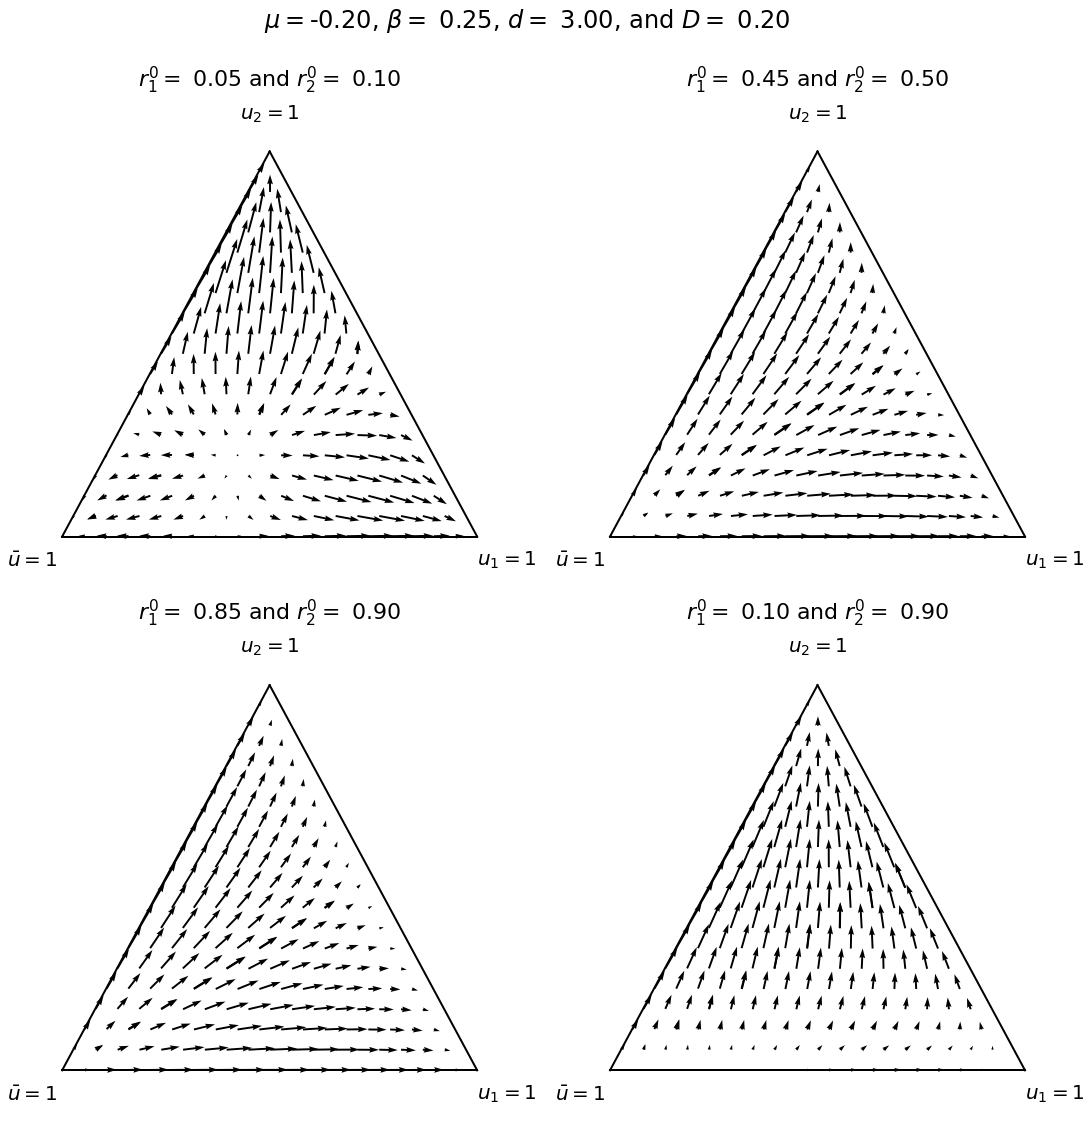

In [31]:

muval = -0.2
betaval = 0.25
dval =3
Dval = 0.2
str_reqs = 'mu ==' + str(muval) +'& beta ==' + str(betaval) + '& d.round(2) ==' + str(dval)+'& D.round(2)==' + str(Dval)

fig,axmat = plt.subplots(2,2,sharex = 'all', sharey = 'all',figsize = (18,18))
r1initvals = [0.05,0.45,0.85,0.1,0.1,0.5,0.9,0.9]
r2initvals = [0.1,0.5,0.9,0.9,0.05,0.45,0.85,0.1]
r1vec = r1initvals[0:4] # only using 1st 4...then can reflect to know behavior for other four
r2vec = r2initvals[0:4]

axflat = axmat.flat
for r1val, r2val, ax in zip(r1vec, r2vec, axflat):
    print(r1val, r2val)
    tax, df_eq_use, df_use =  draw_phasePlot_external(df_10steps, unique_eq, ax, str_reqs, r1val, r2val)
    ts = r'$r_1^0 =$ %0.2f and $r_2^0 =$ %0.2f' %(r1val,r2val)
    ax.set_title(ts, pad = 50, fontsize = 22)


fig.suptitle(r'$\mu =$%0.2f, $\beta =$ %0.2f, $d =$ %0.2f, and $D =$ %0.2f' %(muval,betaval,dval, Dval), fontsize = 24)



In [30]:
# check if eq. above is stable
df_eq_use

,K,pc,d,mu,D,beta,u1eq,u2eq,bueq,r1eq,r2eq,Weq,URstable,NumInitials,C_d,C_D,difference


(0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078, 0.5671502667779078)


ValueError: not enough values to unpack (expected 2, got 0)

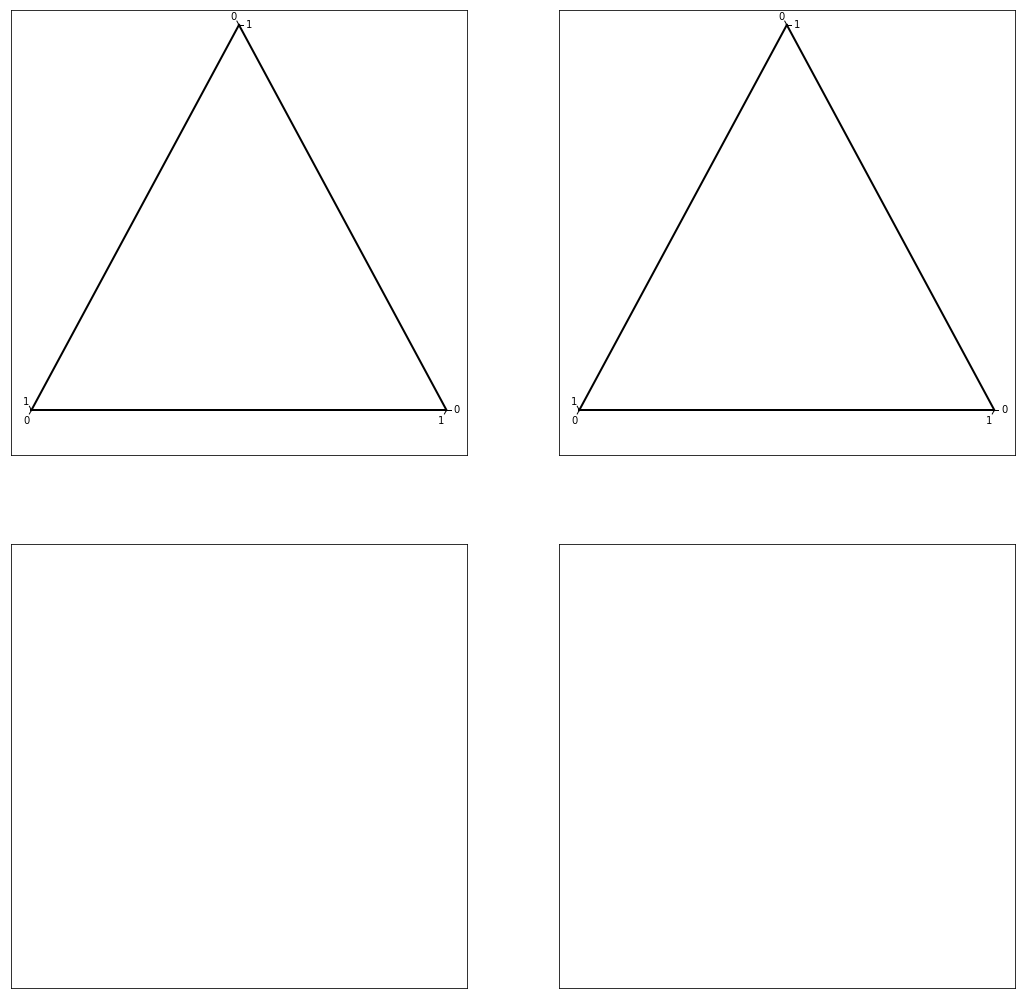

In [164]:

# def draw_tern_plot(str_reqs, df,df_eq, r1val,r2val,tax):
    
#     df_show = df.query(str_reqs)
#     df_show = df_show.copy().query('r1init.round(2) ==@r1val.round(2) & r2init.round(2) == @r2val.round(2)')
#     dfeq_use = df_eq.copy().query(str_reqs)

#     for u1,u2,c,m in zip(dfeq_use.u1eq,dfeq_use.u2eq,dfeq_use.colors, dfeq_use.marker):
#         ax.scatter(u1,u2,color = c, marker = m, s = 500)
    
    
#     ax.scatter(df_show.u1init, df_show.u2init)
    
#     ax.plot([0,1],[1,0], color = 'k')
#     u1_0 = df_show.u1init.values
#     u2_0 = df_show.u2init.values

#     u1_hat = df_show.u1eq.values
#     u2_hat = df_show.u2eq.values


#     for i in range(0,len(u1_hat)):
#         dx = u1_hat[i] - u1_0[i]
#         dy = u2_hat[i] - u2_0[i]
        
#         #want arrow slightly away from point
#         h = np.sqrt(dx**2 + dy**2)
#         costheta = dx/h
#         sintheta = dy/h
        
#         if h > 0.05:
#             h1 = 0.05
#             dy1 = (h-h1)*sintheta
#             dx1 = (h-h1)*costheta
        
#             ax.arrow(u1_0[i], u2_0[i], dx1, dy1,
#                      length_includes_head=True, head_width=.04, head_length=0.04)

#     ax.set_title(r'$r_1^0 =$ %.2f, $r_2^0 =$ %.2f'%(r1val,r2val), fontsize = 22)
#     ax.set_xlim([-0.1,1.1]); plt.ylim([-0.1,1.1])
#     right_side = ax.spines["right"]
#     right_side.set_visible(False)
#     top_side = ax.spines['top']
#     top_side.set_visible(False)
#     return(dfeq_use,ax)
    

    

muval = -0.2
betaval = 0.25
dval = 0.5
Dval = 0.2
str_reqs = 'mu ==' + str(muval) +'& beta ==' + str(betaval) + '& d.round(2) ==' + str(dval)+'& D.round(2)==' + str(Dval)

fig,axmat = plt.subplots(2,2,sharex = 'all', sharey = 'all',figsize = (18,18))
r1initvals = [0.05,0.45,0.85,0.1,0.1,0.5,0.9,0.9]
r2initvals = [0.1,0.5,0.9,0.9,0.05,0.45,0.85,0.1]
r1init = r1initvals[0:4] # only using 1st 4...then can reflect to know behavior for other four
r2init = r2initvals[0:4]
R1, R2 = np.meshgrid(r1initvals, r2initvals)
[r1vec, r2vec] = [np.ndarray.flatten(R1)[0:4], np.ndarray.flatten(R2)[0:4]]
axflat = axmat.flat
for r1val, r2val, ax in zip(r1vec, r2vec, axflat):
    dfeq_use, ax =  draw_tern_plot(str_reqs, df,df_eq, r1val,r2val,ax)

fig.suptitle(r'$\mu =$%0.2f, $\beta =$ %0.2f, $d =$ %0.2f, and $D =$ %0.2f' %(muval,betaval,dval, Dval), fontsize = 24)





In [149]:
points = ((0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85), (0.05, 0.1, 0.85))
((0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.243799644294545), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449), (0.3781001778503607, 0.3781001778550943, 0.2437996442945449))

xs, xy = helpers.project_sequence(points)

In [295]:
df.D.unique()

array([0.2, 0.4, 0.6, 0.8, 1. , 0. ])

In [290]:
dfeq_use

,index,K,pc,d,mu,D,beta,u1eq,u2eq,bueq,...,Weq,URstable,lambdastar,NumInitials,C_d,C_D,Difference,LearningSuccess,marker,colors
2478,2478.0,0.996758,0.000687,3.0,-0.2,1.0,0.25,0.000787,0.997749,0.001464,...,1.750003,1.0,0.571003,21.0,0.000670,0.000000,0.996962,0.998536,+,k
2479,2479.0,0.996758,0.000687,3.0,-0.2,1.0,0.25,0.001383,0.001383,0.997235,...,1.002061,1.0,0.499908,9.0,-0.007136,-0.002759,0.000000,0.002766,s,b
2480,2480.0,0.996758,0.000687,3.0,-0.2,1.0,0.25,0.997749,0.000787,0.001464,...,1.750003,1.0,0.571003,24.0,0.000670,0.000000,0.996962,0.998536,+,k
